<a href="https://colab.research.google.com/github/Sa-Fi/Crop-pest-and-disease-detection/blob/main/CNN_Model_for(grabCut_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/leaf-disease

 99% 2.00G/2.01G [00:30<00:00, 96.8MB/s]
100% 2.01G/2.01G [00:30<00:00, 70.8MB/s]


In [2]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/leaf-disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
!ls

'CCMT Dataset'		   kaggle.json	      sample_data
'CCMT dataset(Grab_Cut)'   leaf-disease.zip


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [5]:
# Define classes and subclasses
classes = ['Cashew', 'Cassava', 'Maize', 'Tomato']
subclasses = {
    'Cashew': ['anthracnose', 'gumosis', 'healthy', 'leaf miner', 'red rust'],
    'Cassava': ['bacterial blight', 'brown spot', 'green mite', 'healthy', 'mosaic'],
    'Maize': ['fall armyworm', 'grasshopper', 'healthy', 'leaf beetle', 'leaf blight', 'leaf spot', 'streak virus'],
    'Tomato': ['healthy', 'leaf blight', 'leaf curl', 'septoria leaf spot', 'verticulium wilt']
}

data = []  # To store images as arrays
labels = []  # To store labels
main_folder = '/content/CCMT dataset(Grab_Cut)/CCMT dataset(Grab_Cut)'
pbar = tqdm(total=len(classes) * len(subclasses))
# Read images and assign labels
for class_name in classes:
    for subclass_name in subclasses[class_name]:
        folder_path = os.path.join(main_folder, class_name, subclass_name)
        for filename in os.listdir(folder_path):
           # if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(folder_path, filename)
                # image = Image.open(image_path)
                image = cv2.imread(image_path)
                if image is not None:
                  image = cv2.resize(image,(150,150))
                  image_array = np.array(image)
                  data.append(image_array)
                  labels.append(class_name + '_' + subclass_name)
                  pbar.update(1)
                else:
                  print(f"Skipping file: {image_path}")
pbar.close()

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

25103it [00:58, 431.65it/s]


In [6]:
len(data)

25103

In [7]:
type(data)

list

In [8]:
data[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Text(0.5, 1.0, 'Label: Cashew_anthracnose, Encoded Label: 0')

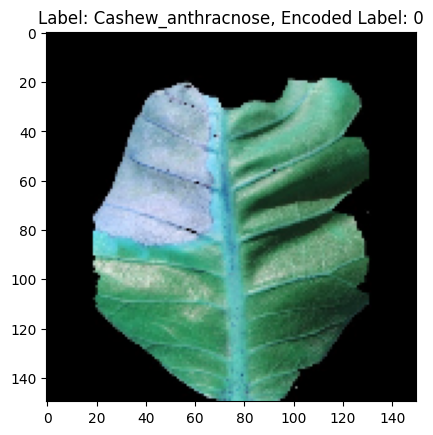

In [29]:
plt.imshow(data[0])
plt.title(f"Label: {labels[0]}, Encoded Label: {encoded_labels[0]}")


Text(0.5, 1.0, 'Label: Tomato_septoria leaf spot, Encoded Label: 20')

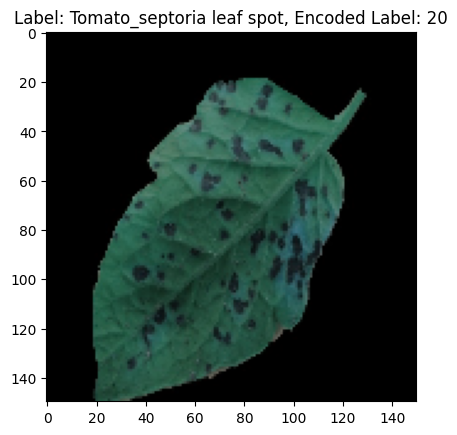

In [31]:
plt.imshow(data[24000])
plt.title(f"Label: {labels[24000]}, Encoded Label: {encoded_labels[24000]}")

In [9]:
print(encoded_labels)

[ 0  0  0 ... 21 21 21]


In [10]:
print('type of data :',type(data[0]))
print("Shape of the image :",data[0].shape)
print("type of the labels :",type(labels))
print("type of the encoded labels :",type(encoded_labels))

type of data : <class 'numpy.ndarray'>
Shape of the image : (150, 150, 3)
type of the labels : <class 'list'>
type of the encoded labels : <class 'numpy.ndarray'>


In [11]:
x = np.array(data)
y = np.array(encoded_labels)

In [12]:
print("The shape of x :",x.shape)
print("The shape of y :",y.shape)

The shape of x : (25103, 150, 150, 3)
The shape of y : (25103,)


In [13]:
x,y = shuffle(x,y,random_state = 101)


In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =101)

In [15]:
type(x_train)

numpy.ndarray

In [16]:
y_train[0]

4

In [17]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(150,150,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))

model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(22,activation='softmax'))

In [18]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['acc'])

In [19]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

In [20]:
y_train_encoded[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [21]:
history = model.fit(x_train,y_train_encoded,epochs = 30,validation_split=0.1)

Epoch 1/30
565/565 [==============================] - 71s 95ms/step - loss: 2.9134 - acc: 0.1396 - val_loss: 3.4663 - val_acc: 0.1000
Epoch 2/30
565/565 [==============================] - 52s 92ms/step - loss: 2.5927 - acc: 0.2064 - val_loss: 3.0080 - val_acc: 0.1339
Epoch 3/30
565/565 [==============================] - 52s 92ms/step - loss: 2.3363 - acc: 0.2727 - val_loss: 2.3511 - val_acc: 0.2678
Epoch 4/30
565/565 [==============================] - 52s 92ms/step - loss: 2.1663 - acc: 0.3183 - val_loss: 2.1856 - val_acc: 0.3151
Epoch 5/30
565/565 [==============================] - 52s 91ms/step - loss: 1.9812 - acc: 0.3558 - val_loss: 1.8966 - val_acc: 0.3763
Epoch 6/30
565/565 [==============================] - 52s 91ms/step - loss: 1.8503 - acc: 0.3922 - val_loss: 1.8245 - val_acc: 0.3942
Epoch 7/30
565/565 [==============================] - 52s 91ms/step - loss: 1.7230 - acc: 0.4277 - val_loss: 1.7719 - val_acc: 0.4176
Epoch 8/30
565/565 [==============================] - 51s 91ms

In [26]:
model.save('/content/drive/MyDrive/Deep learning model/CNN_model_30epoch_47%')

In [24]:
loss, accuracy = model.evaluate(x_test, y_test_encoded)

# Print the accuracy
print(f"Test accuracy: {accuracy * 100:.2f}%")

157/157 [==============================] - 3s 21ms/step - loss: 2.1312 - acc: 0.4738
Test accuracy: 47.38%


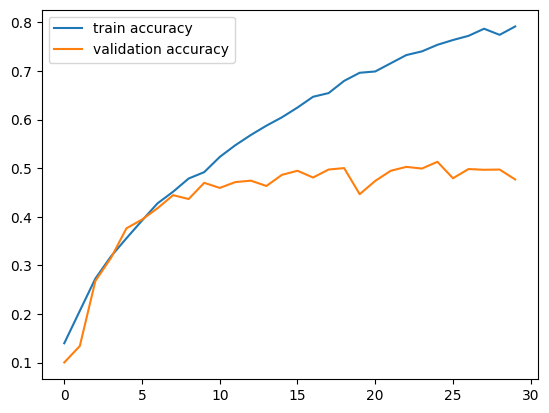

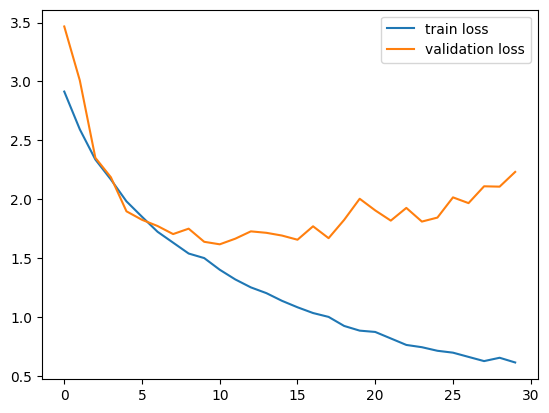

In [25]:
h = history
#plot the accuracy value
plt.plot(h.history['acc'],label='train accuracy')
plt.plot(h.history['val_acc'],label = 'validation accuracy')
plt.legend()
plt.show()

#plot the loss value
plt.plot(h.history['loss'],label = 'train loss')
plt.plot(h.history['val_loss'],label = 'validation loss')
plt.legend()
plt.show()

In [31]:
pred = model.predict(x_test)
accuracy_score(y_test,pred)

157/157 [==============================] - 3s 21ms/step


ValueError: ignored

In [32]:
confusion_matrix(y_test,pred)

ValueError: ignored

In [25]:
# Assuming 'y_test_encoded' is a NumPy array or similar data structure
print("Shape of y_test_encoded:", y_test_encoded.shape)
print("Data type of y_test_encoded:", type(y_test_encoded))

Shape of y_test_encoded: (5021, 22)
Data type of y_test_encoded: <class 'numpy.ndarray'>


In [26]:

# Assuming 'pred' is a NumPy array or similar data structure
print("Shape of pred:", pred.shape)
print("Data type of pred:", type(pred))

Shape of pred: (5021, 22)
Data type of pred: <class 'numpy.ndarray'>


In [34]:
y_pred = model.predict(x_test).round(2)
y_pred

157/157 [==============================] - 3s 21ms/step


array([[0.04, 0.  , 0.02, ..., 0.04, 0.43, 0.18],
       [0.08, 0.3 , 0.1 , ..., 0.01, 0.02, 0.01],
       [0.01, 0.  , 0.  , ..., 0.01, 0.37, 0.34],
       ...,
       [0.08, 0.  , 0.58, ..., 0.  , 0.01, 0.  ],
       [0.06, 0.13, 0.07, ..., 0.01, 0.03, 0.01],
       [0.03, 0.  , 0.01, ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [35]:
model.predict(np.expand_dims(x_test[0],axis=0)).round(2)

1/1 [==============================] - 1s 974ms/step


array([[0.04, 0.  , 0.02, 0.  , 0.  , 0.02, 0.02, 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.15, 0.04, 0.43, 0.18]],
      dtype=float32)

In [36]:
np.argmax(model.predict(np.expand_dims(x_test[0],axis=0)).round(2))

1/1 [==============================] - 0s 20ms/step


20

In [37]:
y_test[0]

2

In [39]:
model.evaluate(x_test,y_test_encoded)

157/157 [==============================] - 4s 22ms/step - loss: 2.5309 - acc: 0.2593


[2.530916452407837, 0.25931090116500854]